# Summary of work

This notebook explores how closely unique molecular structures within each group resemble eachother using the Jaccard or Tanimoto index. This should help determine which compound groups are most suitable for identification of new compounds via similarity.

# Load libraries and data

In [1]:
from rdkit import Chem
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import percentileofscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from matchms.similarity import FingerprintSimilarity
from matchms.filtering import add_fingerprint

from mass_differences.processing import get_ids_for_unique_inchikeys
import csv

RDKit WARNING: [10:15:58] Enabling RDKit 2019.09.3 jupyter extensions


In [52]:
# Specify directories
data_dir = "/mnt/scratch/ding013/MS2ChemClass/hooft_data/datasets/ALL_GNPS_210409_positive/"
embedding_path='/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv'
classification_path='/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/'
fingerprint_dir = "/mnt/scratch/ding013/MS2ChemClass/fingerprint/"

# Define functions
def jaccard_similarity_for_groups(metadata_df, var, spectra, min_class_size=50):
    class_count = metadata_df[var].value_counts(ascending=False)
    selected_classes = class_count[class_count>=min_class_size]
    similarity_measure = FingerprintSimilarity(similarity_measure="jaccard")
    print(len(selected_classes), "classes exceed minimum class size")

    jaccard_array = []
    for group in selected_classes.index:
        #print(group)
        bool_index = (metadata_df[var] == group) & (metadata_df["inchi"] != "")
        selection = metadata_df[bool_index]
        spectra_selection = [spectra[i] for i in selection.index]
        similarity_matrix = similarity_measure.matrix(spectra_selection, spectra_selection)
        similarity_triangle = similarity_matrix[np.triu_indices(n=len(selection))]
        jaccard_array += [similarity_triangle]
    return selected_classes, jaccard_array


def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize = 8) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [42]:
# Load original spectra file
spectra = pd.read_pickle(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated.pickle")
#spectrum_vectors = pd.read_csv(embedding_path, sep = "\t", header = None)

In [30]:
# Load the class predictions for each inchikey
inchikey_classifications = pd.read_csv(classification_path+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 

# Prep data

In [44]:
# Add fingerprints to spectra to calculate Tanimoto distance later
for i, spectrum in enumerate(spectra):
    spectra[i] = add_fingerprint(spectra[i], fingerprint_type="daylight", nbits=2048)
pickle.dump(spectra, open(fingerprint_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_fingerprint.pickle", "wb"))

RDKit WARNING: [11:17:12] WARNING: not removing hydrogen atom without neighbors


In [82]:
# Load spectra with fingerprints
spectra = pickle.load(open(fingerprint_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_fingerprint.pickle", "rb"))
# spectra = pickle.load(open(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v.pickle", "rb"))

In [83]:
print(len(spectra))

187152


In [84]:
# Get metadata; we retrieve the inchikey and source instrument for all spectra, and look up the predicted classes for the inchikey.
spectrum_id = []; inchikeys = []; inchi = []; instruments = []

for spec in spectra:
    inchikeys.append(spec.get("inchikey"))
    inchi.append(spec.get("inchi"))
    instruments.append(spec.get("instrument"))
    spectrum_id.append(spec.get("spectrum_id"))
spectrum_metadata = pd.DataFrame({"ID": spectrum_id, "inchikey":inchikeys, "inchi": inchi, "instrument": instruments})

# We drop all spectral records without inchikey and match the remaining records with npclassifier and classyfire compound class predictions
spectrum_metadata['spectrum_index'] = spectrum_metadata.index # Merging dataframes changes the row order, so we're saving the index now as a column to restore it after merging
spectrum_metadata = spectrum_metadata[spectrum_metadata["inchikey"] != ""]
spectrum_metadata = spectrum_metadata.merge(inchikey_classifications, how='left', on='inchikey', sort=False).sort_values(by="spectrum_index")

spectrum_metadata["planar_inchi"] = [key[:14] for key in spectrum_metadata["inchikey"]] # Add shortened planar inchikey to metadata
inchi_spectra = [spectra[i] for i in spectrum_metadata["spectrum_index"]] # Subset the spectra to only the spectra with inchikeys
print(len(inchi_spectra), "out of", len(spectra), "spectra are annotated with an Inchikey")
spectrum_metadata.reset_index(drop = True, inplace = True) # Match indices to inchi_spectra indices

# We retrieve the IDs of spectra with unique planar Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(inchi_spectra)
print(f'{len(unique_inchi)} out of {len(inchi_spectra)} annotated spectra have a unique Inchikey')

# Quick check to see that the spectra and spectrum_metadata match up
print("Spectra and metadata match:", inchi_spectra[17000].get("spectrum_id") == spectrum_metadata["ID"][17000])

187152 out of 187152 spectra are annotated with an Inchikey
16360 out of 187152 annotated spectra have a unique Inchikey
Spectra and metadata match: True


In [85]:
del(spectra)

# Jaccard / Tanimoto distance
The Jaccard index, also known as the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. It was developed by Paul Jaccard, originally giving the French name coefficient de communauté, and independently formulated again by T. Tanimoto. Thus, the Tanimoto index or Tanimoto coefficient are also used in some fields. 

# NPClassifier classes

In [111]:
# Get Jaccard similarities
npc_classes, jaccard_npc_class = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="npc_class_results", 
                                                                    spectra = inchi_spectra, min_class_size=4)
# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
npc_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_npc_class], index = npc_classes.index).sort_values()

365 classes exceed minimum class size


In [108]:
a= list(npc_class_percentile_scores.values)
print(a[363])

2.079706825469543


In [109]:
r=0
for i,v in enumerate(label_orderedby_accuracy):
    if v not in npc_class_percentile_scores.index:
        r+=1
        print(v, label_orderedby_accuracy[i])

Amino fatty acids Amino fatty acids
Carotenoids (C40 Carotenoids (C40
Indole diketopiperazine alkaloids (L-Trp Indole diketopiperazine alkaloids (L-Trp
Aflatoxins Aflatoxins
Ingenane diterpenoids Ingenane diterpenoids
Anabaenopeptins Anabaenopeptins
Lanostane Lanostane
Atisane diterpenoids Atisane diterpenoids
Capsaicins and Capsaicinoids Capsaicins and Capsaicinoids
Cyanopeptolins Cyanopeptolins
Cyclamides Cyclamides
Epoxyeicosatrienoic acids Epoxyeicosatrienoic acids
Flavonolignans Flavonolignans
Hydroxy-hydroperoxyeicosatrienoic acids Hydroxy-hydroperoxyeicosatrienoic acids
Isoprostanes Isoprostanes
Scalarane sesterterpenoids Scalarane sesterterpenoids
Serratane triterpenoids Serratane triterpenoids


In [113]:
r

79

In [112]:
r=0
for i,v in enumerate(npc_class_percentile_scores.index):
    if v not in label_orderedby_accuracy:
        r+=1
        print(v)

Linear peptides; Microginins
Taxane diterpenoids; Tetracyclic diterpenoids
Linear peptides; Lipopeptides; Microginins
Corynanthe type; Yohimbine-like alkaloids
Open-chain polyketides; Sphingoid bases
Cyanopeptolins; Cyclic peptides; Depsipeptides
Anabaenopeptins; Cyclic peptides
Cucurbitane triterpenoids; Cycloartane triterpenoids
Cyclic peptides; Microcystins
Iridoids monoterpenoids; Secoiridoid monoterpenoids
Tetracyclic diterpenoids; Tigliane diterpenoids
Aspidosperma type; Aspidosperma-Iboga hybrid type (Vinca alkaloids)
Drimane sesquiterpenoids; Spriromeroterpenoids; Tetraketide meroterpenoids
Drimane sesquiterpenoids; Spriromeroterpenoids
Cyanopeptolins; Cyclic peptides; Depsipeptides; Lipopeptides
Aminosugars; Polysaccharides
Isoflavanones; Isoflavones
Capsaicins and Capsaicinoids; Phenylalanine-derived alkaloids
Pyridine alkaloids; Quinolizidine alkaloids
Isoflavones; Neoflavonoids
Acyl phloroglucinols; Depsides and depsidones
Aspidosperma type; Corynanthe type
Indole diketopip

In [79]:
inchi_spectra[:10]

In [77]:
print(len(unique_inchi))

16360


In [80]:
metadata_df = spectrum_metadata.iloc[unique_inchi]
print(len(metadata_df))

16360


In [81]:
metadata_df

,ID,inchikey,inchi,instrument,spectrum_index,smiles,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,npc_superclass_results,npc_pathway_results,npc_isglycoside,planar_inchi
0,CCMSLIB00000001547,IYDKWWDUBYWQGF-NNAZGLEUSA-N,InChI=1S/C48H72N10O12/c1-25(2)22-36-45(66)57-3...,qTof,0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,Organic compounds,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Hybrid peptides,Cyclic peptides; Microcystins,Oligopeptides,Amino acids and Peptides,0,IYDKWWDUBYWQGF
1,CCMSLIB00000001548,KNGPFNUOXXLKCN-ZNCJFREWSA-N,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,qTof,1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Cyclic depsipeptides,Cyclic peptides,Oligopeptides,Amino acids and Peptides,0,KNGPFNUOXXLKCN
3,CCMSLIB00000001550,CGZKSPLDUIRCIO-RPCRKUJJSA-N,InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17...,Ion Trap,3,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,Organic compounds,Organoheterocyclic compounds,Indoles and derivatives,NaN,Indoles and derivatives,NaN,NaN,Shikimates and Phenylpropanoids,0,CGZKSPLDUIRCIO
4,CCMSLIB00000001552,USXIYWCPCGVOKF-LERJCCFDSA-N,"InChI=1S/C27H34Cl2N2O9S2/c1-13-17(9-8-10-27(7,...",qTof,4,C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Cyclic depsipeptides,Cyclic peptides; Depsipeptides,Oligopeptides,Amino acids and Peptides; Polyketides,0,USXIYWCPCGVOKF
6,CCMSLIB00000001554,WCNJVJCYRBJSLC-BCJYPDSRSA-N,InChI=1S/C56H82N8O11/c1-30(2)24-34(8)44-52(70)...,qTof,6,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,Organic compounds,Phenylpropanoids and polyketides,Macrolactams,NaN,Macrolactams,Cyclic peptides,Oligopeptides,Amino acids and Peptides,0,WCNJVJCYRBJSLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187054,CCMSLIB00006112253,QRYRORQUOLYVBU-VBKZILBWSA-N,InChI=1S/C20H28O4/c1-11(2)13-10-12-6-7-14-19(3...,Orbitrap,187054,CC(C)c1cc2c(c(O)c1O)[C@@]1(C(=O)O)CCCC(C)(C)[C...,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Diterpenoids,Diterpenoids,Abietane diterpenoids,Diterpenoids,Terpenoids,0,QRYRORQUOLYVBU
187061,CCMSLIB00006112262,DUWPGRAKHMEPCM-IZZDOVSWSA-N,InChI=1S/C20H20O4/c1-13(2)3-9-16-19(23)12-10-1...,Orbitrap,187061,O=C(C=CC1=CC=C(O)C=C1)C2=CC=C(O)C(=C2O)CC=C(C)C,Organic compounds,Phenylpropanoids and polyketides,"Linear 1,3-diarylpropanoids",Chalcones and dihydrochalcones,3-prenylated chalcones,Chalcones,Flavonoids,Shikimates and Phenylpropanoids,0,DUWPGRAKHMEPCM
187088,CCMSLIB00006112307,NPJICTMALKLTFW-OFUAXYCQSA-N,InChI=1S/C35H60O6/c1-7-22(20(2)3)9-8-21(4)26-1...,Orbitrap,187088,CCC(CCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)OC5C(C...,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,Stigmastanes and derivatives,Stigmastanes and derivatives,Stigmastane steroids,Steroids,Terpenoids,1,NPJICTMALKLTFW
187091,CCMSLIB00006112312,OVMFOVNOXASTPA-SDSMHRFWSA-N,InChI=1S/C26H28O14/c27-6-13-18(32)21(35)23(37)...,Orbitrap,187091,O=C1C=C(OC2=C1C(O)=C(C(O)=C2C3OC(CO)C(O)C(O)C3...,Organic compounds,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides,Flavonoid 8-C-glycosides,Flavones,Flavonoids,Shikimates and Phenylpropanoids,0,OVMFOVNOXASTPA


In [57]:
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/NPC_accuracy_LDA_Class_allgroups.pickle', 'rb') as f:
    lda_class_allgroup_accuracy = pickle.load(f)

In [58]:

with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/npc_label_belong.csv', 'r') as f:
    npc_label_belong = csv.reader(f,delimiter=',')
    npc_label_belong_list = []
    for r in npc_label_belong:
        npc_label_belong_list.append(r)
    print(len(npc_label_belong_list))

3


In [62]:
accuracy_desending_index = [i[0] for i in sorted(enumerate(lda_class_allgroup_accuracy['accuracy']), key=lambda k: k[1], reverse=True)]
accuracy_desending = [lda_class_allgroup_accuracy['accuracy'][i] for i in accuracy_desending_index]
label_orderedby_accuracy = [lda_class_allgroup_accuracy['labels'][i] for i in accuracy_desending_index]
groupsize = [(lda_class_allgroup_accuracy['group_size_train'][i]+lda_class_allgroup_accuracy['group_size_test'][i]) for i in range(len(lda_class_allgroup_accuracy['group_size_train']))]
groupsize_orderedby_accuracy = [groupsize[i] for i in accuracy_desending_index]


label_belong_index = [npc_label_belong_list[1].index(v) for v in label_orderedby_accuracy]
label_class = [npc_label_belong_list[1][i] for i in label_belong_index]
label_superclass = [npc_label_belong_list[2][i] for i in label_belong_index]
label_pathway = [npc_label_belong_list[0][i] for i in label_belong_index]
ordered_labels = [(npc_label_belong_list[0][i]+' <<< '+npc_label_belong_list[2][i]+' <<< '+npc_label_belong_list[1][i])for i in label_belong_index]

In [68]:
jaccard_labels = list(npc_class_percentile_scores.index)
jaccard_values = list(npc_class_percentile_scores.values)

In [69]:
new_jaccard_values=[]
for i,v in enumerate(label_orderedby_accuracy):
    if v in jaccard_labels:
        jcd_value = jaccard_values[jaccard_labels.index(v)]
        new_jaccard_values.append(jcd_value)
  #  else:
      #  new_jaccard_values.append('NA')

In [70]:
len(new_jaccard_values)

295

In [64]:
import matplotlib as mpl

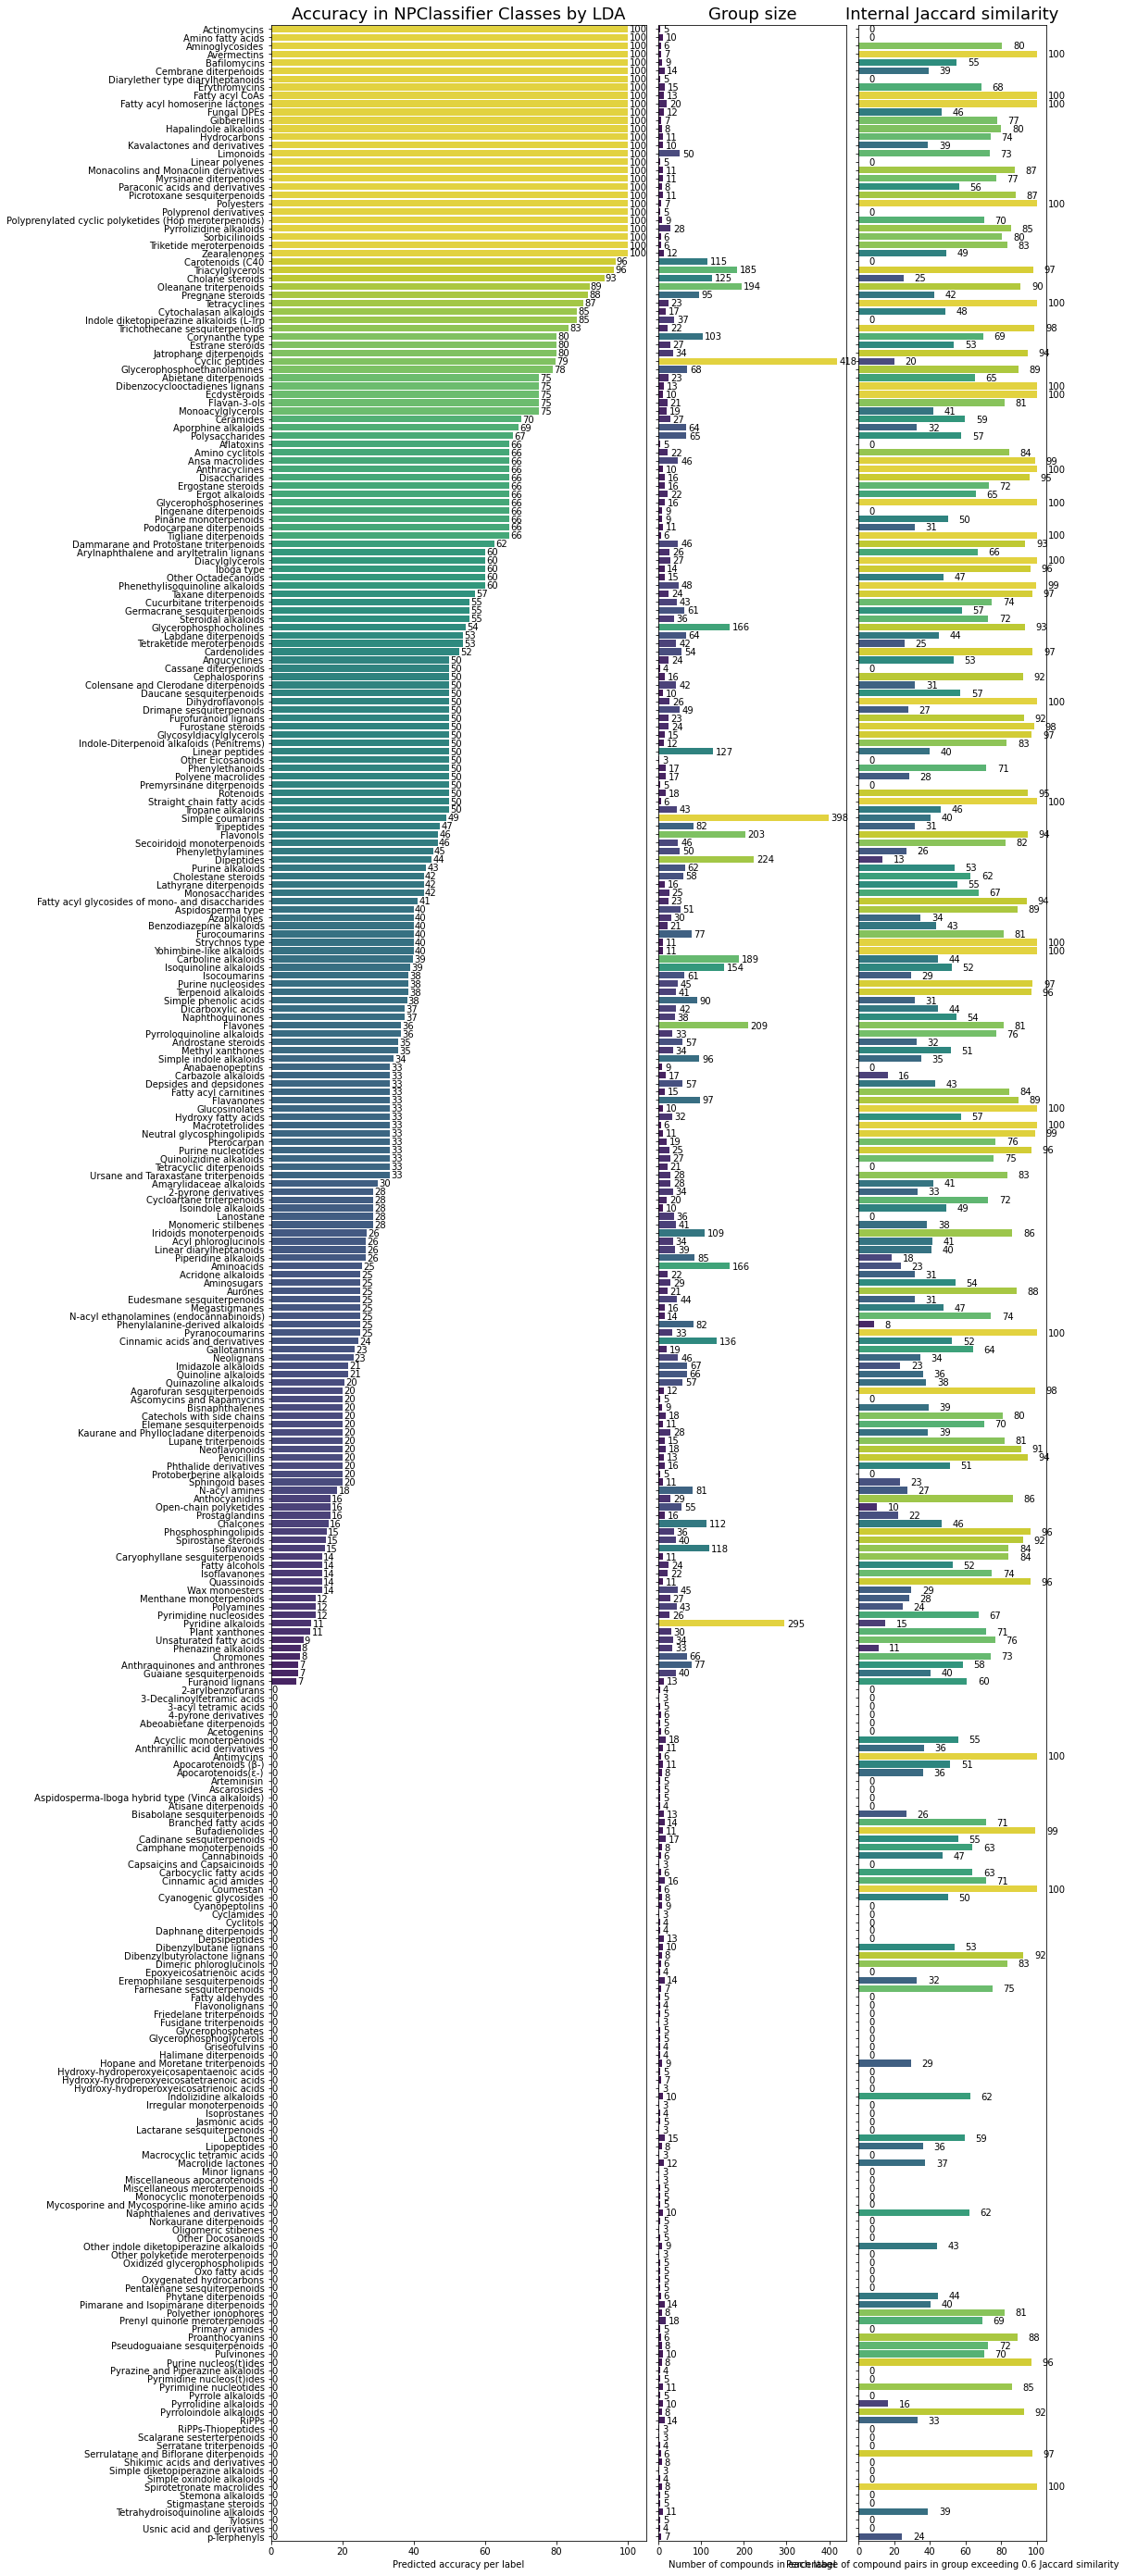

In [88]:

# Plot group size vs. accuracy vs. Jaccard similarity
f, axes = plt.subplots(1, 3, figsize=(15, 50), gridspec_kw={'width_ratios': [2, 1, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = [i*100 for i in accuracy_desending], y = label_orderedby_accuracy, ax = axes[0],palette=mpl.cm.viridis(accuracy_desending))
fig1.set_title('Accuracy in NPClassifier Classes by LDA', fontsize=18)
fig1.set_xlabel("Predicted accuracy per label")
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = groupsize_orderedby_accuracy, y = label_orderedby_accuracy, ax = axes[1],palette=mpl.cm.viridis(groupsize_orderedby_accuracy))
fig2.set_title("Group size", fontsize = 18)
fig2.set_xlabel("Number of compounds in each label")
#fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

fig3 = sns.barplot(x = new_jaccard_values, y = label_orderedby_accuracy, ax = axes[2],palette=mpl.cm.viridis(np.array(new_jaccard_values)*.01))
fig3.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig3.set_title("Internal Jaccard similarity", fontsize=18)
show_values_on_bars(fig3, "h", 6)
fig3.set_yticklabels([]);


#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier classes.svg")

In [ ]:
# Plot group size vs. accuracy
f, axes = plt.subplots(1, 2, figsize=(15, 45), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = accuracy_desending, y = ordered_labels, ax = axes[0])
fig1.set_title('Accuracy in NPClassifier classes by LDA', fontsize=18)
fig1.set_xlabel("Predicted accuracy per label")
#show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = groupsize_orderedby_accuracy, y = ordered_labels, ax = axes[1], color = "#4C72B0")
fig2.set_title("Group size in NPClassifier classes by LDA", fontsize = 18)
fig2.set_xlabel("Number of compounds in each label")
#fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier classes.svg")

In [61]:
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/NPC_accuracy_LDA_Superclass_allgroups.pickle', 'rb') as f:
    lda_class_allgroup_accuracy = pickle.load(f)

accuracy_desending_index = [i[0] for i in sorted(enumerate(lda_class_allgroup_accuracy['group_size_train']), key=lambda k: k[1], reverse=True)]
accuracy_desending = [lda_class_allgroup_accuracy['accuracy'][i] for i in accuracy_desending_index]
label_orderedby_accuracy = [lda_class_allgroup_accuracy['labels'][i] for i in accuracy_desending_index]
groupsize_orderedby_accuracy = [lda_class_allgroup_accuracy['group_size_train'][i] for i in accuracy_desending_index]

label_belong_index = [npc_label_belong_list[1].index(v) for v in label_orderedby_accuracy]

ordered_labels = [(npc_label_belong_list[0][i]+' <<< '+npc_label_belong_list[2][i])for i in label_belong_index]

ValueError: 'Flavonoids' is not in list

In [ ]:
# Plot group size vs. accuracy
f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = accuracy_desending, y = ordered_labels, ax = axes[0])
fig1.set_title('Accuracy in NPClassifier classes by LDA', fontsize=18)
fig1.set_xlabel("Predicted accuracy per label")
#show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = groupsize_orderedby_accuracy, y = ordered_labels, ax = axes[1], color = "#4C72B0")
fig2.set_title("Group size in NPClassifier classes by LDA", fontsize = 18)
fig2.set_xlabel("Number of compounds in each label")
#fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier classes.svg")

## ClassyFire classes

In [54]:
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/CF_accuracy_LDA_subclass_allgroups.pickle', 'rb') as f:
    lda_class_allgroup_accuracy = pickle.load(f)

with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/cf_label_belong.csv', 'r') as f:
    cf_label_belong = csv.reader(f,delimiter=',')
    cf_label_belong_list = []
    for r in cf_label_belong:
        cf_label_belong_list.append(r)
    print(len(cf_label_belong_list))


3


In [55]:
accuracy_desending_index = [i[0] for i in sorted(enumerate(lda_class_allgroup_accuracy['group_size_train']), key=lambda k: k[1], reverse=True)]
accuracy_desending = [lda_class_allgroup_accuracy['accuracy'][i] for i in accuracy_desending_index]
label_orderedby_accuracy = [lda_class_allgroup_accuracy['labels'][i] for i in accuracy_desending_index]
groupsize_orderedby_accuracy = [lda_class_allgroup_accuracy['group_size_train'][i] for i in accuracy_desending_index]

In [59]:
label_belong_index = [npc_label_belong_list[0].index(v) for v in label_orderedby_accuracy]
label_class = [npc_label_belong_list[1][i] for i in label_belong_index]
label_superclass = [npc_label_belong_list[2][i] for i in label_belong_index]
label_pathway = [npc_label_belong_list[0][i] for i in label_belong_index]
ordered_labels = [(npc_label_belong_list[0][i]+' <<< '+npc_label_belong_list[1][i]+' <<< '+npc_label_belong_list[2][i])for i in label_belong_index]

ValueError: 'Amino acids' is not in list

In [ ]:
# Plot group size vs. accuracy
f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = accuracy_desending, y = ordered_labels, ax = axes[0])
fig1.set_title('Accuracy in NPClassifier classes by LDA', fontsize=18)
fig1.set_xlabel("Predicted accuracy per label")
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = groupsize_orderedby_accuracy, y = ordered_labels, ax = axes[1], color = "#4C72B0")
fig2.set_title("Group size in NPClassifier classes by LDA", fontsize = 18)
fig2.set_xlabel("Number of compounds in each label")
#fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier classes.svg")

# Classyfire superclasses

In [151]:
# Get Jaccard similarities
cf_superclasses, jaccard_cf_superclass = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_superclass", 
                                                                          spectra = inchi_spectra, min_class_size=50)

# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
cf_superclass_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_cf_superclass], index = cf_superclasses.index).sort_values()

11 classes exceed minimum class size


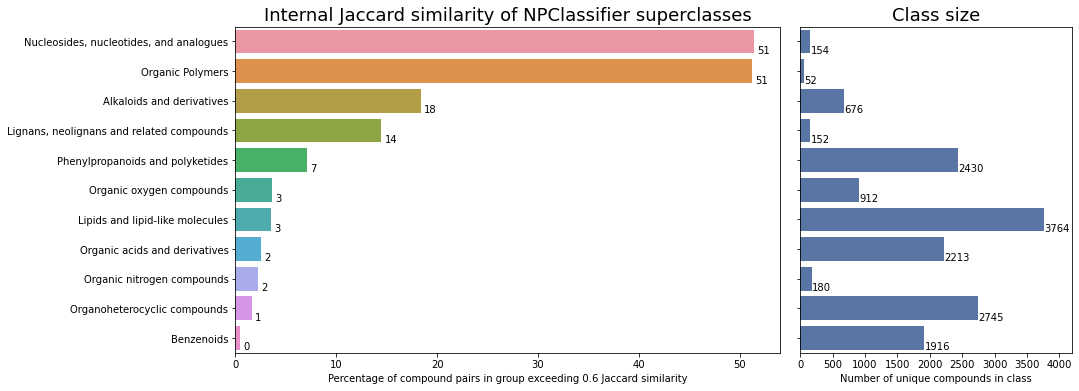

In [152]:
cf_superclasses = cf_superclasses.reindex(cf_superclass_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_superclass_percentile_scores.values, y = cf_superclass_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal Jaccard similarity of NPClassifier superclasses", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_superclasses.values, y = cf_superclasses.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,4200)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier superclasses.svg")

# Classyfire classes

In [153]:
# Get Jaccard similarities
cf_classes, jaccard_cf_class = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_class", 
                                                                   spectra = inchi_spectra, min_class_size=50)

# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
cf_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_cf_class], index = cf_classes.index).sort_values()

47 classes exceed minimum class size


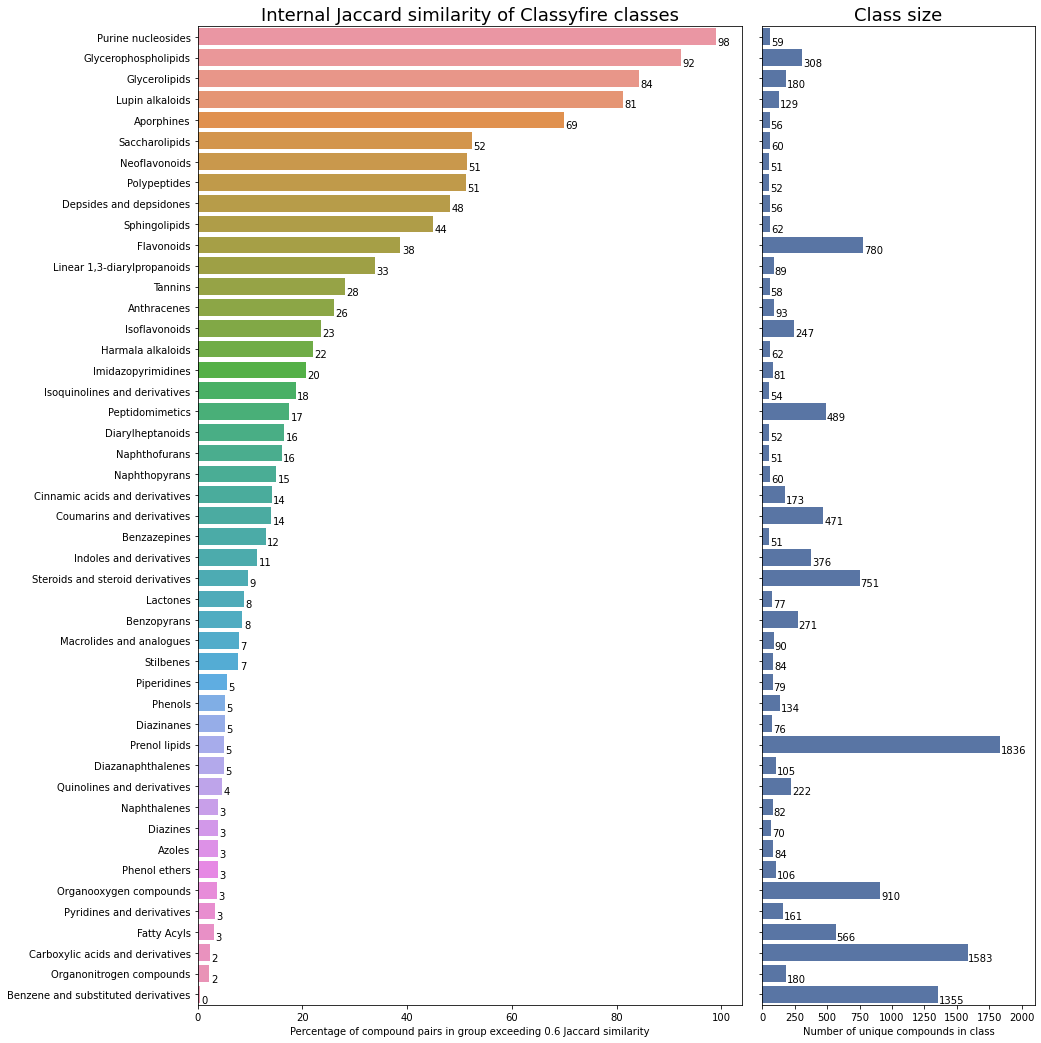

In [154]:
cf_classes = cf_classes.reindex(cf_class_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_class_percentile_scores.values, y = cf_class_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal Jaccard similarity of Classyfire classes", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_classes.values, y = cf_classes.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,2100)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - Classyfire classes.svg")

# Classyfire subclasses

In [155]:
# Get Jaccard similarities
cf_subclasses, jaccard_cf_subclass = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_subclass", 
                                                                      spectra = inchi_spectra, min_class_size=50)

cf_subclass_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_cf_subclass], index = cf_subclasses.index).sort_values()

52 classes exceed minimum class size


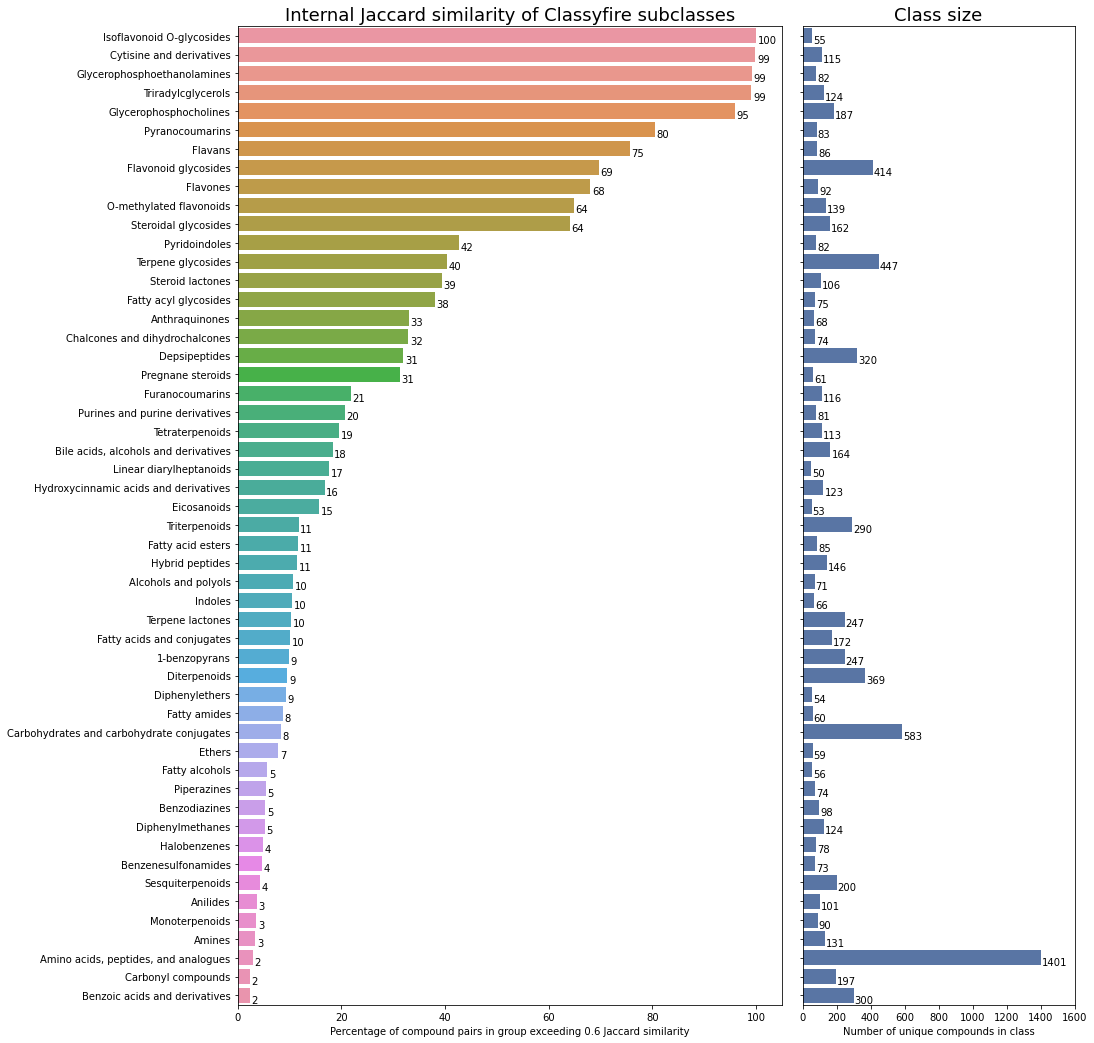

In [156]:
cf_subclasses = cf_subclasses.reindex(cf_subclass_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_subclass_percentile_scores.values, y = cf_subclass_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal Jaccard similarity of Classyfire subclasses", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_subclasses.values, y = cf_subclasses.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,1600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - Classyfire subclasses.svg")

# Which classification method results in the largest high similarity groups?

In [254]:
# Determine number of compounds in the high similarity groups
classifications = ["NPClassifier classes", "Classyfire superclasses", "Classyfire classes", "Classyfire subclasses"]
thresholds = [30, 40 , 50 , 60, 70]
n_results = pd.DataFrame()

for threshold in thresholds:
    n_compounds = pd.Series([sum(npc_classes[npc_class_percentile_scores>threshold]),
                             sum(cf_superclasses[cf_superclass_percentile_scores>threshold]),
                             sum(cf_classes[cf_class_percentile_scores>threshold]),
                             sum(cf_subclasses[cf_subclass_percentile_scores>threshold])],
                            index = classifications)
    n_results = pd.concat([n_results, n_compounds], axis = 1)
n_results.columns = thresholds; n_results

,30,40,50,60,70
NPClassifier classes,3251,2977,2508,2088,1798
Classyfire superclasses,206,206,206,0,0
Classyfire classes,1882,1013,895,732,676
Classyfire subclasses,2772,2068,1539,1539,732


In [230]:
# Determine percentage of compounds from classes in high similarity groups
p_results = n_results
for i, class_sum in enumerate([sum(npc_classes), sum(cf_superclasses), sum(cf_classes), sum(cf_subclasses)]):
    p_results.iloc[i] = p_results.iloc[i]/class_sum
p_results = p_results.round(2); p_results

,30,40,50,60,70
NPClassifier classes,0.41,0.37,0.31,0.26,0.23
Classyfire superclasses,0.01,0.01,0.01,0.00,0.00
Classyfire classes,0.14,0.08,0.07,0.06,0.05
Classyfire subclasses,0.31,0.23,0.17,0.17,0.08


In [244]:
# How many compounds were in the considered classes (classes with >50 compounds)?
for class_sum in [sum(npc_classes), sum(cf_superclasses), sum(cf_classes), sum(cf_subclasses)]:
    print(class_sum)

7969
15194
13022
8844


In [246]:
# How many unique compounds were successfully classified?
for classification in ["npc_class_results", "cf_superclass", "cf_class", "cf_subclass"]:
    print(sum(~spectrum_metadata.iloc[unique_inchi][classification].isna()))

13051
15265
15195
12869


# Process output

In [248]:
npc_class_df = pd.DataFrame(npc_class_percentile_scores)
npc_class_df["Classification"] = "NPClassifier class"

In [257]:
output_df = pd.DataFrame()
for i, percentile_scores in enumerate([npc_class_percentile_scores, cf_superclass_percentile_scores, cf_class_percentile_scores, cf_subclass_percentile_scores]):
    df = pd.DataFrame(percentile_scores, columns = ["Score"])
    df["Classification"] = classifications[i]
    output_df = pd.concat([output_df, df])
output_df

,Score,Classification
Pyridine alkaloids; Quinolizidine alkaloids,100.000000,NPClassifier classes
Purine nucleosides,97.096189,NPClassifier classes
Triacylglycerols,96.942168,NPClassifier classes
Ansa macrolides,96.509783,NPClassifier classes
Phenethylisoquinoline alkaloids,94.711538,NPClassifier classes
...,...,...
Monoterpenoids,3.614164,Classyfire subclasses
Amines,3.400416,Classyfire subclasses
"Amino acids, peptides, and analogues",2.952751,Classyfire subclasses
Carbonyl compounds,2.327847,Classyfire subclasses


In [258]:
output_df.to_csv(data_dir+"Internal jaccard similarity per classification group.csv")